In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('seaborn')

from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')


# 1. Import Data

In [199]:
url = 'C:\\Users\\Lee\\Desktop\\GIt\\AIFFEL_first\\Dataton/'
df = pd.read_csv(url +'Stores.csv')

특성	|설명 |	Type
:-------:|:------:|:-----:
Store ID|sotre 번호|int
Store_Area|	store 크기|int
Items_Available|판매 물품 수|int
Daily_Customer_Count|방문객 수	|int
Store_Sales|판매액|int

# 2. EDA & FE

## 2.1. Data Summary

In [200]:
df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [201]:
df.tail()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
891,892,1582,1910,1080,66390
892,893,1387,1663,850,82080
893,894,1200,1436,1060,76440
894,895,1299,1560,770,96610
895,896,1174,1429,1110,54340


In [202]:
print(df.shape)
df.info()

(896, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store ID              896 non-null    int64
 1   Store_Area            896 non-null    int64
 2   Items_Available       896 non-null    int64
 3   Daily_Customer_Count  896 non-null    int64
 4   Store_Sales           896 non-null    int64
dtypes: int64(5)
memory usage: 35.1 KB


In [203]:
df.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000,896.000000
mean,448.500000,1485.409598,1782.035714,786.350446,59351.305804
std,258.797218,250.237011,299.872053,265.389281,17190.741895
min,1.000000,775.000000,932.000000,10.000000,14920.000000
25%,224.750000,1316.750000,1575.500000,600.000000,46530.000000
50%,448.500000,1477.000000,1773.500000,780.000000,58605.000000
75%,672.250000,1653.500000,1982.750000,970.000000,71872.500000
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000


In [204]:
df.isnull().sum()

Store ID                0
Store_Area              0
Items_Available         0
Daily_Customer_Count    0
Store_Sales             0
dtype: int64

In [205]:
df.duplicated().sum()

0

In [206]:
df.drop(['Store ID '],axis=1,inplace=True)

- 5개의 feature 존재
- 결측치는 없다.
- Store_Id는 index이다. -> drop
- feature의 범위가 넓게 퍼져있다 -> log1p변환

In [207]:
df_original = df.copy()

In [208]:
# area feature
df['item_per_area'] = df['Items_Available']/df['Store_Area']
df['customer_per_area'] = df['Daily_Customer_Count']/ df['Store_Area']
df['sales_per_area'] = df['Store_Sales']/ df['Store_Area']

# item feature
df['customer_per_item'] = df['Daily_Customer_Count']/df['Items_Available']
df['sales_per_item'] = df['Store_Sales']/df['Items_Available']

# customer feature
df['sales_per_customer'] = df['Store_Sales']/df['Daily_Customer_Count']

## 2.2. Statistics & Visualization

In [209]:
df_original['sale_qcut'] = pd.qcut(df.Store_Sales,q=5,labels=[1,2,3,4,5])
df['sale_qcut'] = pd.qcut(df.Store_Sales,q=5,labels=[1,2,3,4,5]).astype(int)

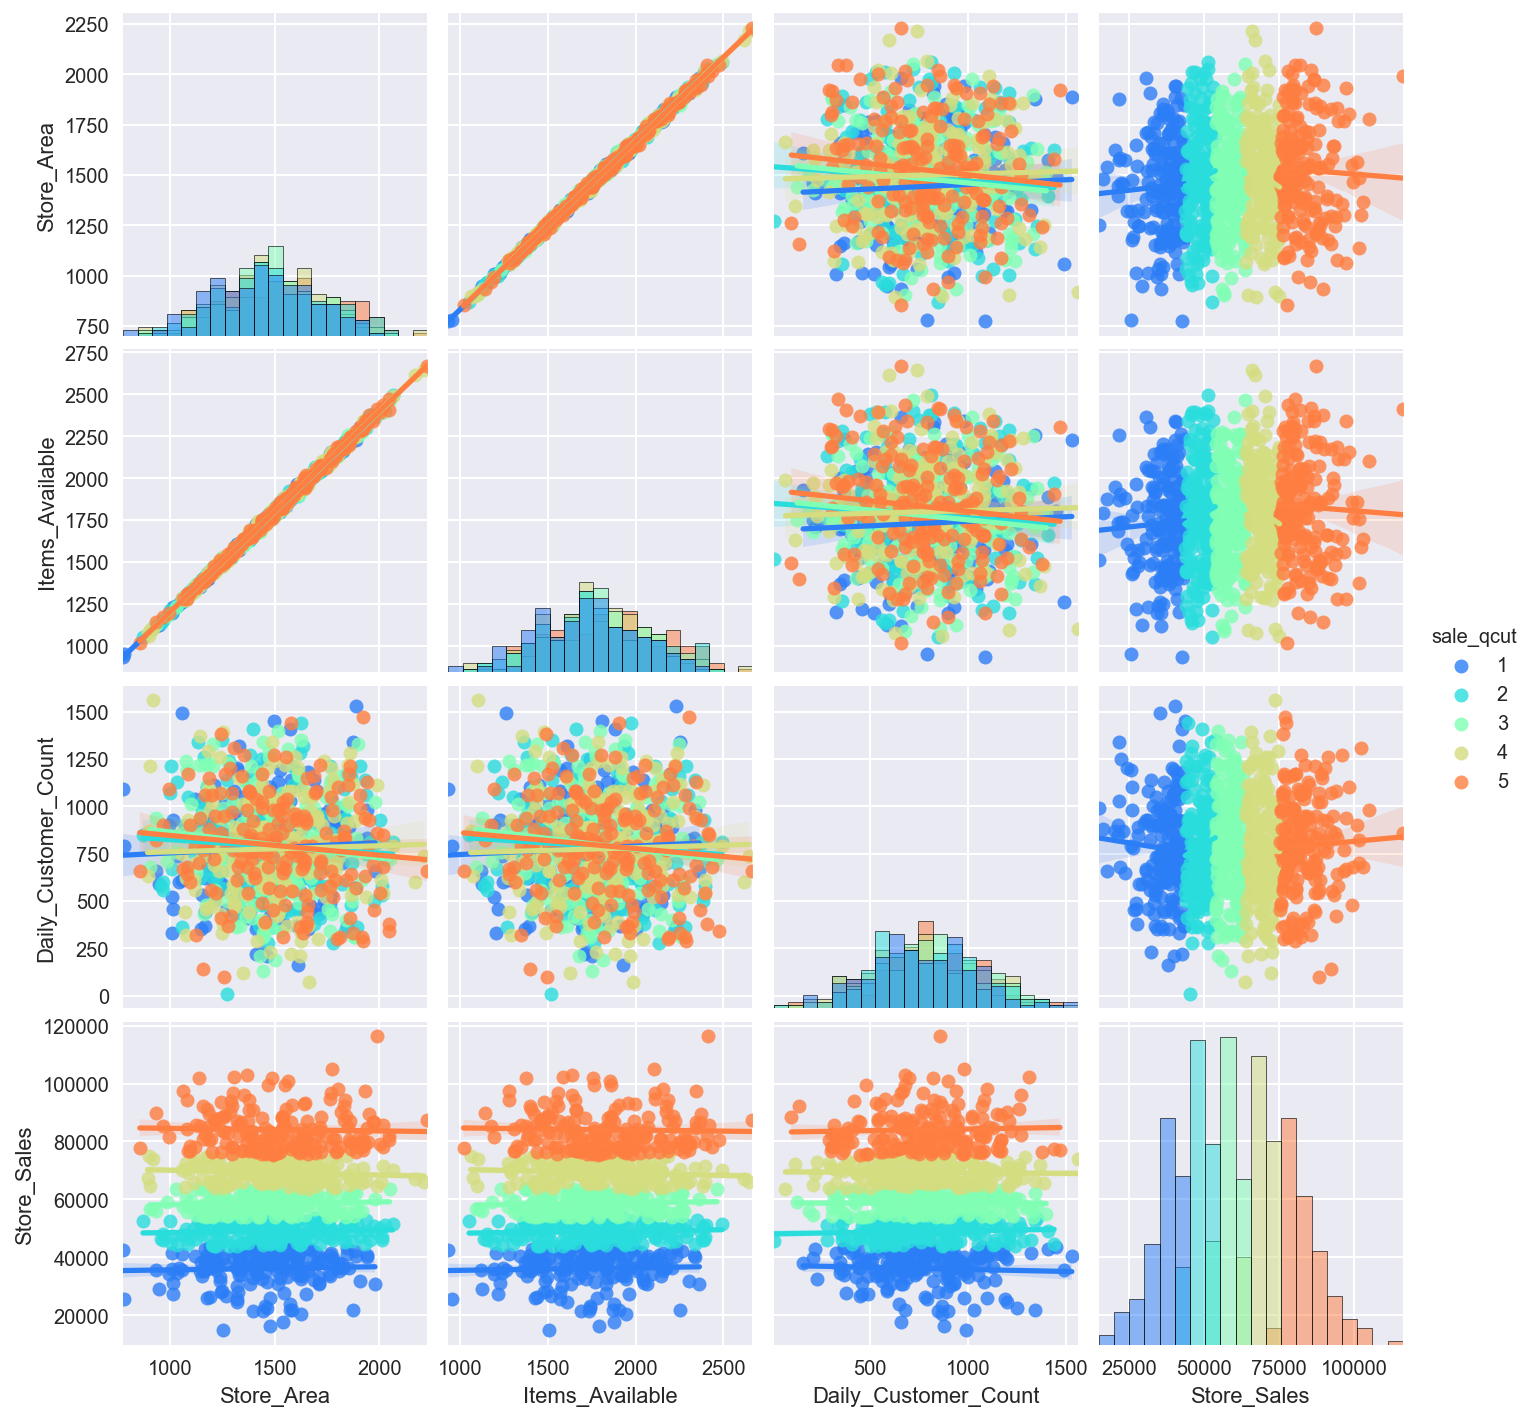

In [210]:
sns.pairplot(df_original,kind='reg',palette='rainbow',hue='sale_qcut',diag_kind="hist")

- pairplot를 통하여 feature간 상관성을 시각적으로 살펴본다. Item_Available와 Store_Area는 상관성이 지나치게 높다

##### 상관성

In [211]:
df_original.corr()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
Store_Area,1.000000,0.998891,-0.041423,0.097474
Items_Available,0.998891,1.000000,-0.040978,0.098849
Daily_Customer_Count,-0.041423,-0.040978,1.000000,0.008629
Store_Sales,0.097474,0.098849,0.008629,1.000000


<AxesSubplot:>

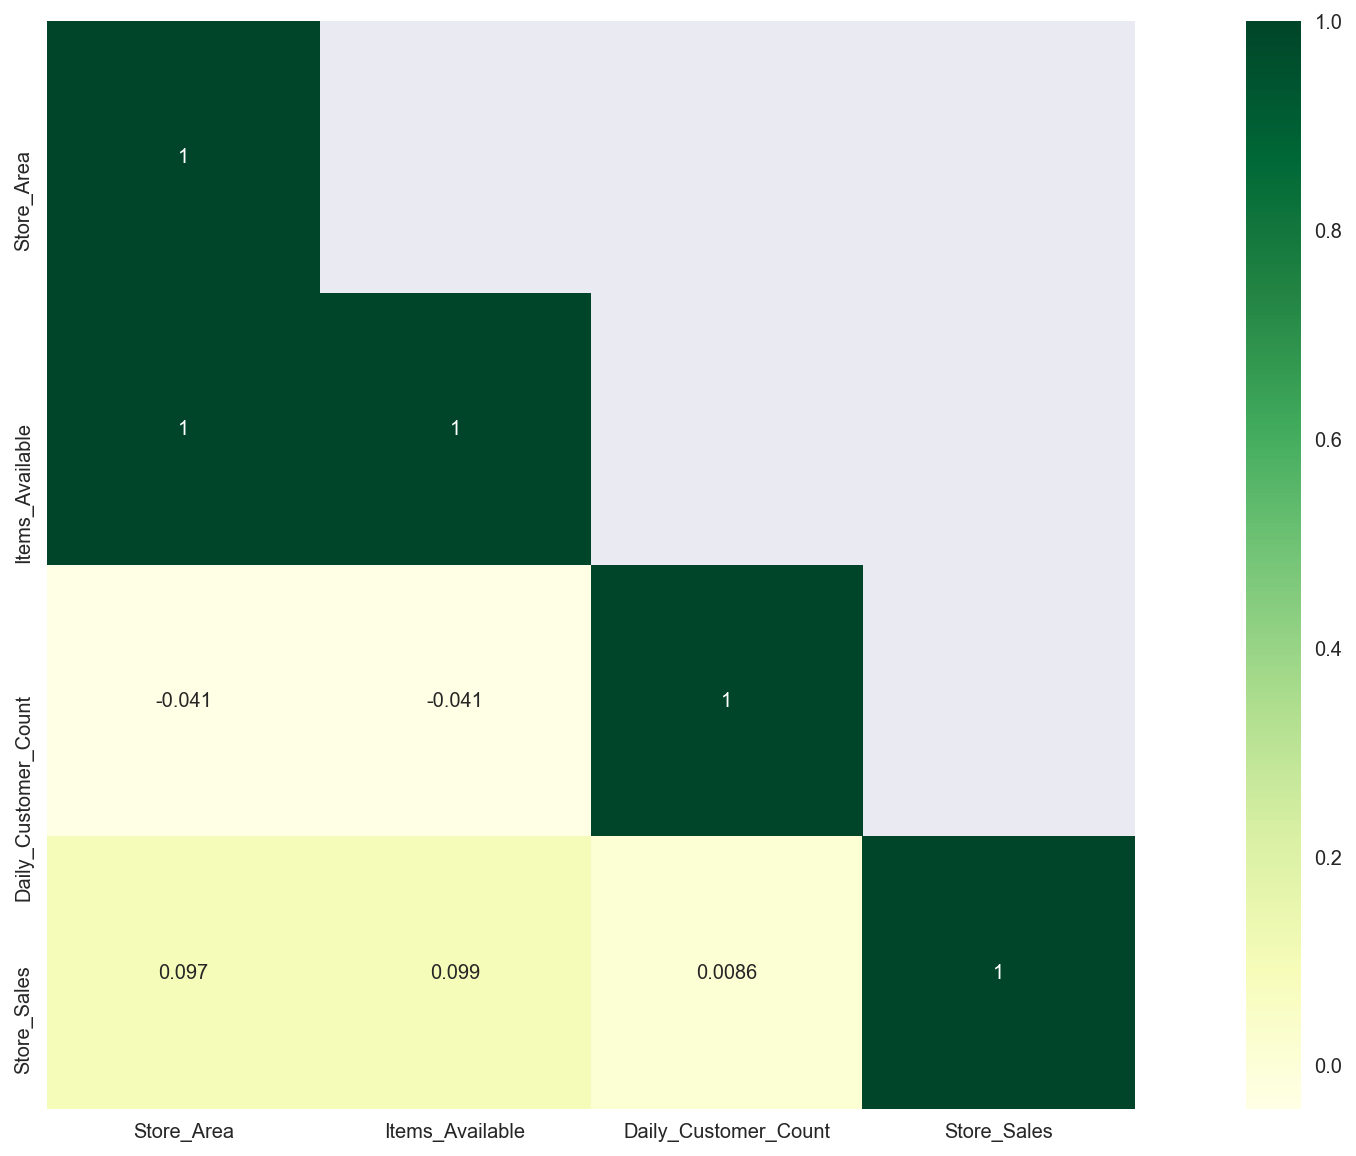

In [212]:
cor = df_original.corr()

mask = np.array(cor)
mask[np.tril_indices_from(mask)]=False #np.tril_indices_from -> 하 삼각형 인덱스 반환
f, ax =plt.subplots(figsize=(20,10))
sns.heatmap(cor ,mask=mask ,square=True ,annot=True ,cmap ='YlGn')   # square 정사각형 모양

<AxesSubplot:>

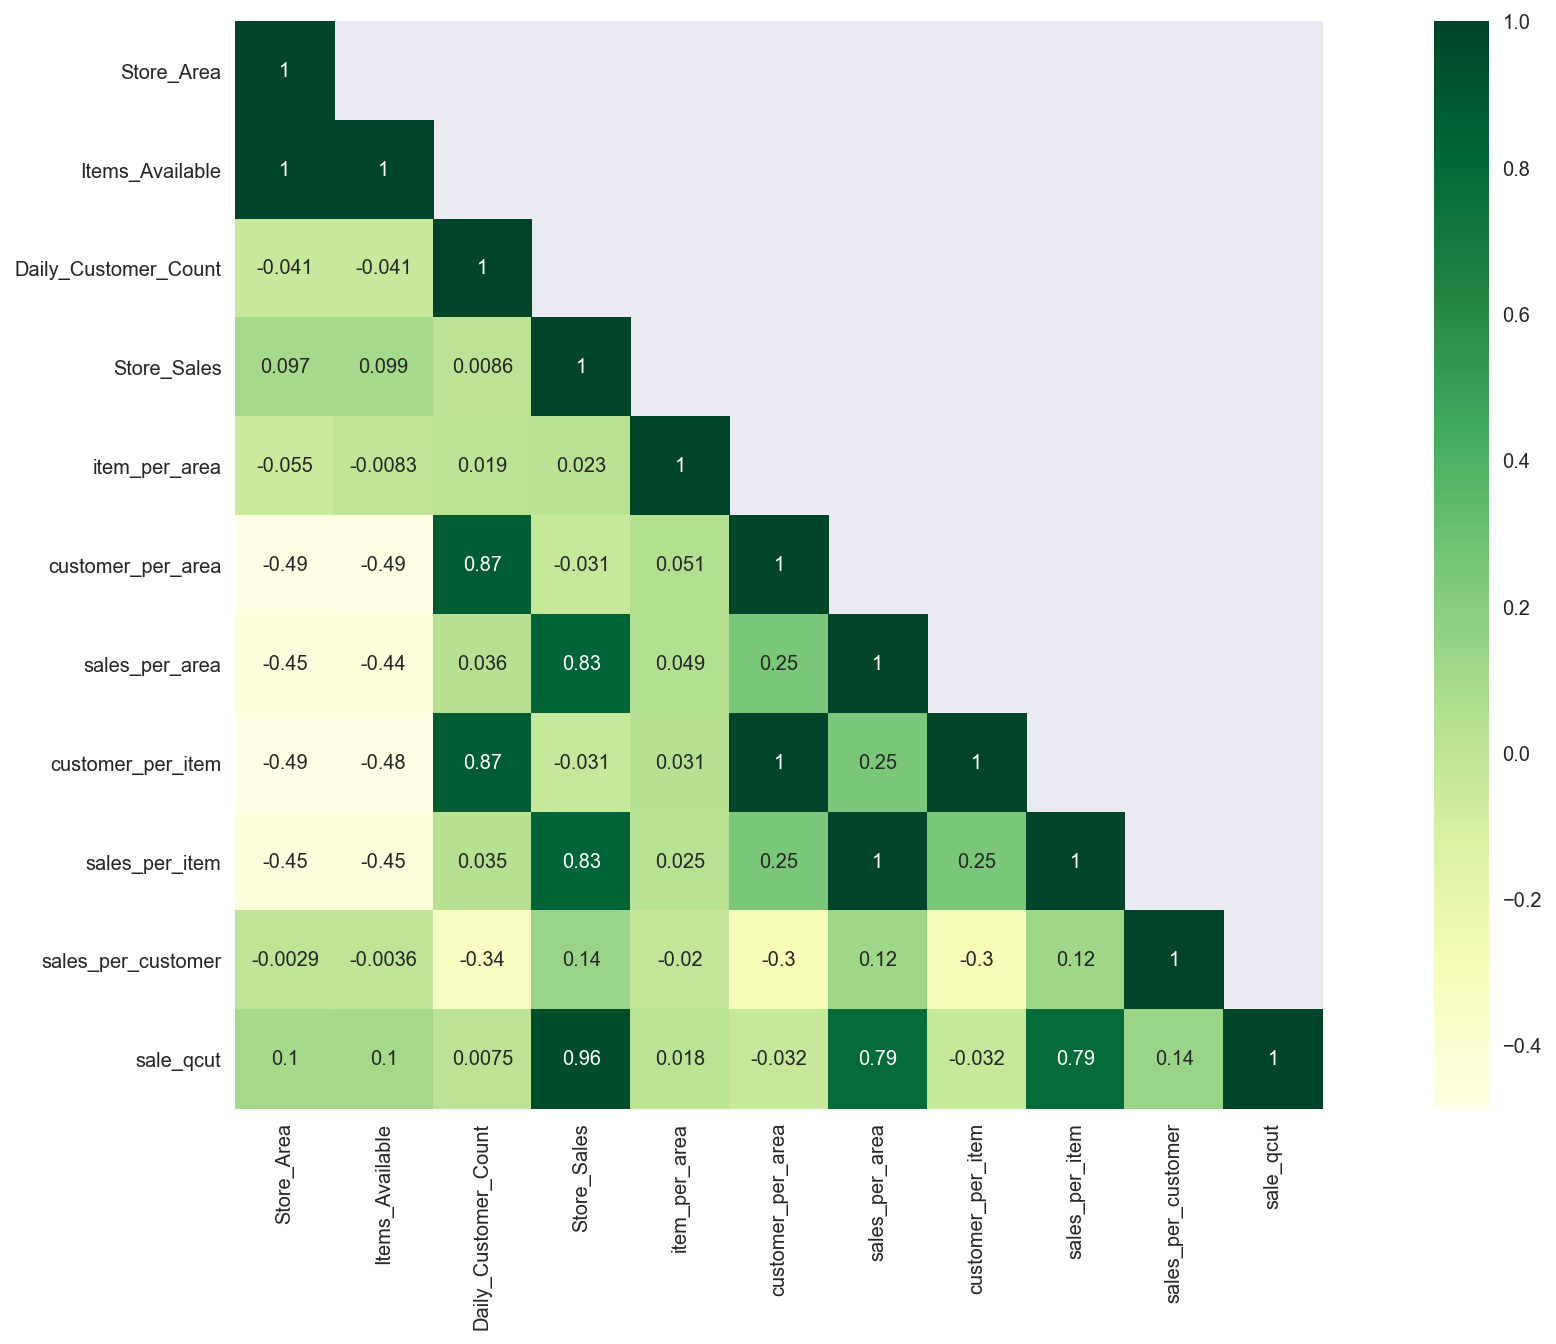

In [213]:
cor = df.corr()

mask = np.array(cor)
mask[np.tril_indices_from(mask)]=False #np.tril_indices_from -> 하 삼각형 인덱스 반환
f, ax =plt.subplots(figsize=(20,10))
sns.heatmap(cor ,mask=mask ,square=True ,annot=True ,cmap ='YlGn')   # square 정사각형 모양

- Stroe_Area와 Items_Available의 상관성이 높다 -> PCA를 통한 차원 축소

In [214]:
pca = PCA(n_components = 1)
df['pca'] = pca.fit_transform(df[['Store_Area','Items_Available']])

In [215]:
df[['pca','Store_Area','Items_Available','Store_Sales']].corr()

,pca,Store_Area,Items_Available,Store_Sales
pca,1.000000,0.999614,0.999813,0.098311
Store_Area,0.999614,1.000000,0.998891,0.097474
Items_Available,0.999813,0.998891,1.000000,0.098849
Store_Sales,0.098311,0.097474,0.098849,1.000000


- PCA를 통하여 파생변수 pca 생성 -> store_area와 items_available과의 상관성이 매우 높다

In [216]:
df.shape

(896, 12)

##### 왜도 첨도  

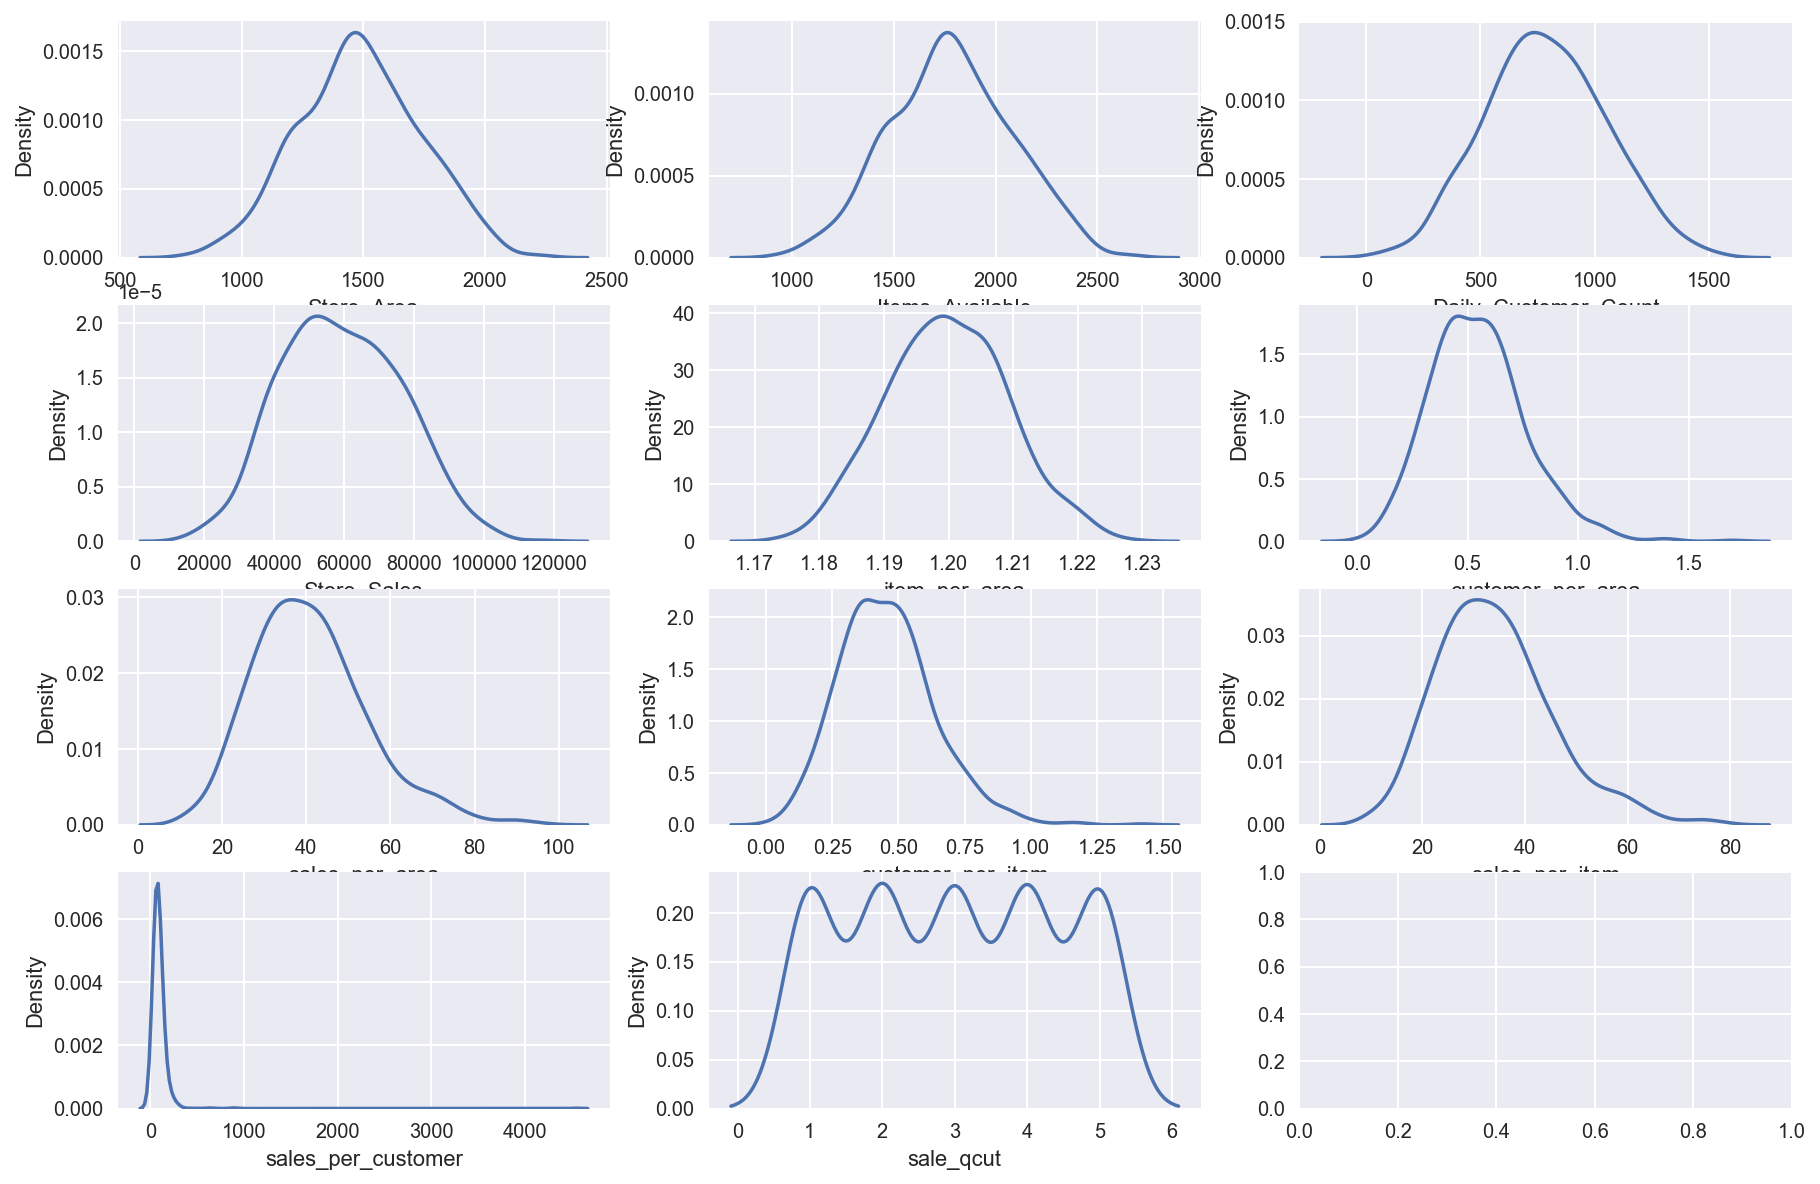

In [217]:
f, ax = plt.subplots(4,3,figsize=(15,10))
count = 0
for row in range(4):
    for col in range(3):
        sns.kdeplot(df.iloc[:,count],ax=ax[row][col])
        count+=1
        if count==11:
            break

In [218]:
df.apply(lambda x:skew(x)).to_frame().sort_values(0,ascending=False)

,0
sales_per_customer,23.271978
sales_per_area,0.715622
sales_per_item,0.712395
customer_per_area,0.660625
customer_per_item,0.659919
Store_Sales,0.148544
Daily_Customer_Count,0.074508
item_per_area,0.069417
Items_Available,0.034382
pca,0.032234


In [219]:
df.apply(lambda x:kurtosis(x)).to_frame().sort_values(0,ascending=False)

,0
sales_per_customer,625.017333
customer_per_item,1.224951
customer_per_area,1.203128
sales_per_area,0.782664
sales_per_item,0.760623
Daily_Customer_Count,-0.264993
item_per_area,-0.266547
Items_Available,-0.286213
pca,-0.287187
Store_Area,-0.287659


- sales_per_customer를 제외한 feature의 왜도는 굉장히 낮다. 데이터가 쏠려있지는 않다.
- sales_per_customer를 제외한 첨도는 0 부근이다.

##### VIF

In [220]:
vif = pd.DataFrame({'columns':df.columns})
li = []
for i in range(df.shape[1]):
    li.append(variance_inflation_factor(df,i))

vif['vif'] = li
vif.sort_values('vif',ascending=False)

,columns,vif
1,Items_Available,3.218544e+06
0,Store_Area,2.290326e+05
11,pca,5.489676e+04
5,customer_per_area,2.136445e+04
7,customer_per_item,2.136032e+04
8,sales_per_item,1.858836e+04
6,sales_per_area,1.850559e+04
4,item_per_area,1.192119e+02
3,Store_Sales,3.726622e+01
2,Daily_Customer_Count,2.219655e+01


In [221]:
vif = pd.DataFrame({'columns':df_original.columns})
li = []
for i in range(df_original.shape[1]):
    li.append(variance_inflation_factor(df_original,i))

vif['vif'] = li
vif.sort_values('vif',ascending=False)

,columns,vif
1,Items_Available,16414.240434
0,Store_Area,16371.091763
3,Store_Sales,103.292815
4,sale_qcut,49.045201
2,Daily_Customer_Count,8.448709


- items_avaliable 와 store_area의 vif가 굉장히 높다. pca를 통하여 'pca' 특성을 생성하여 높다.

##### 이상치

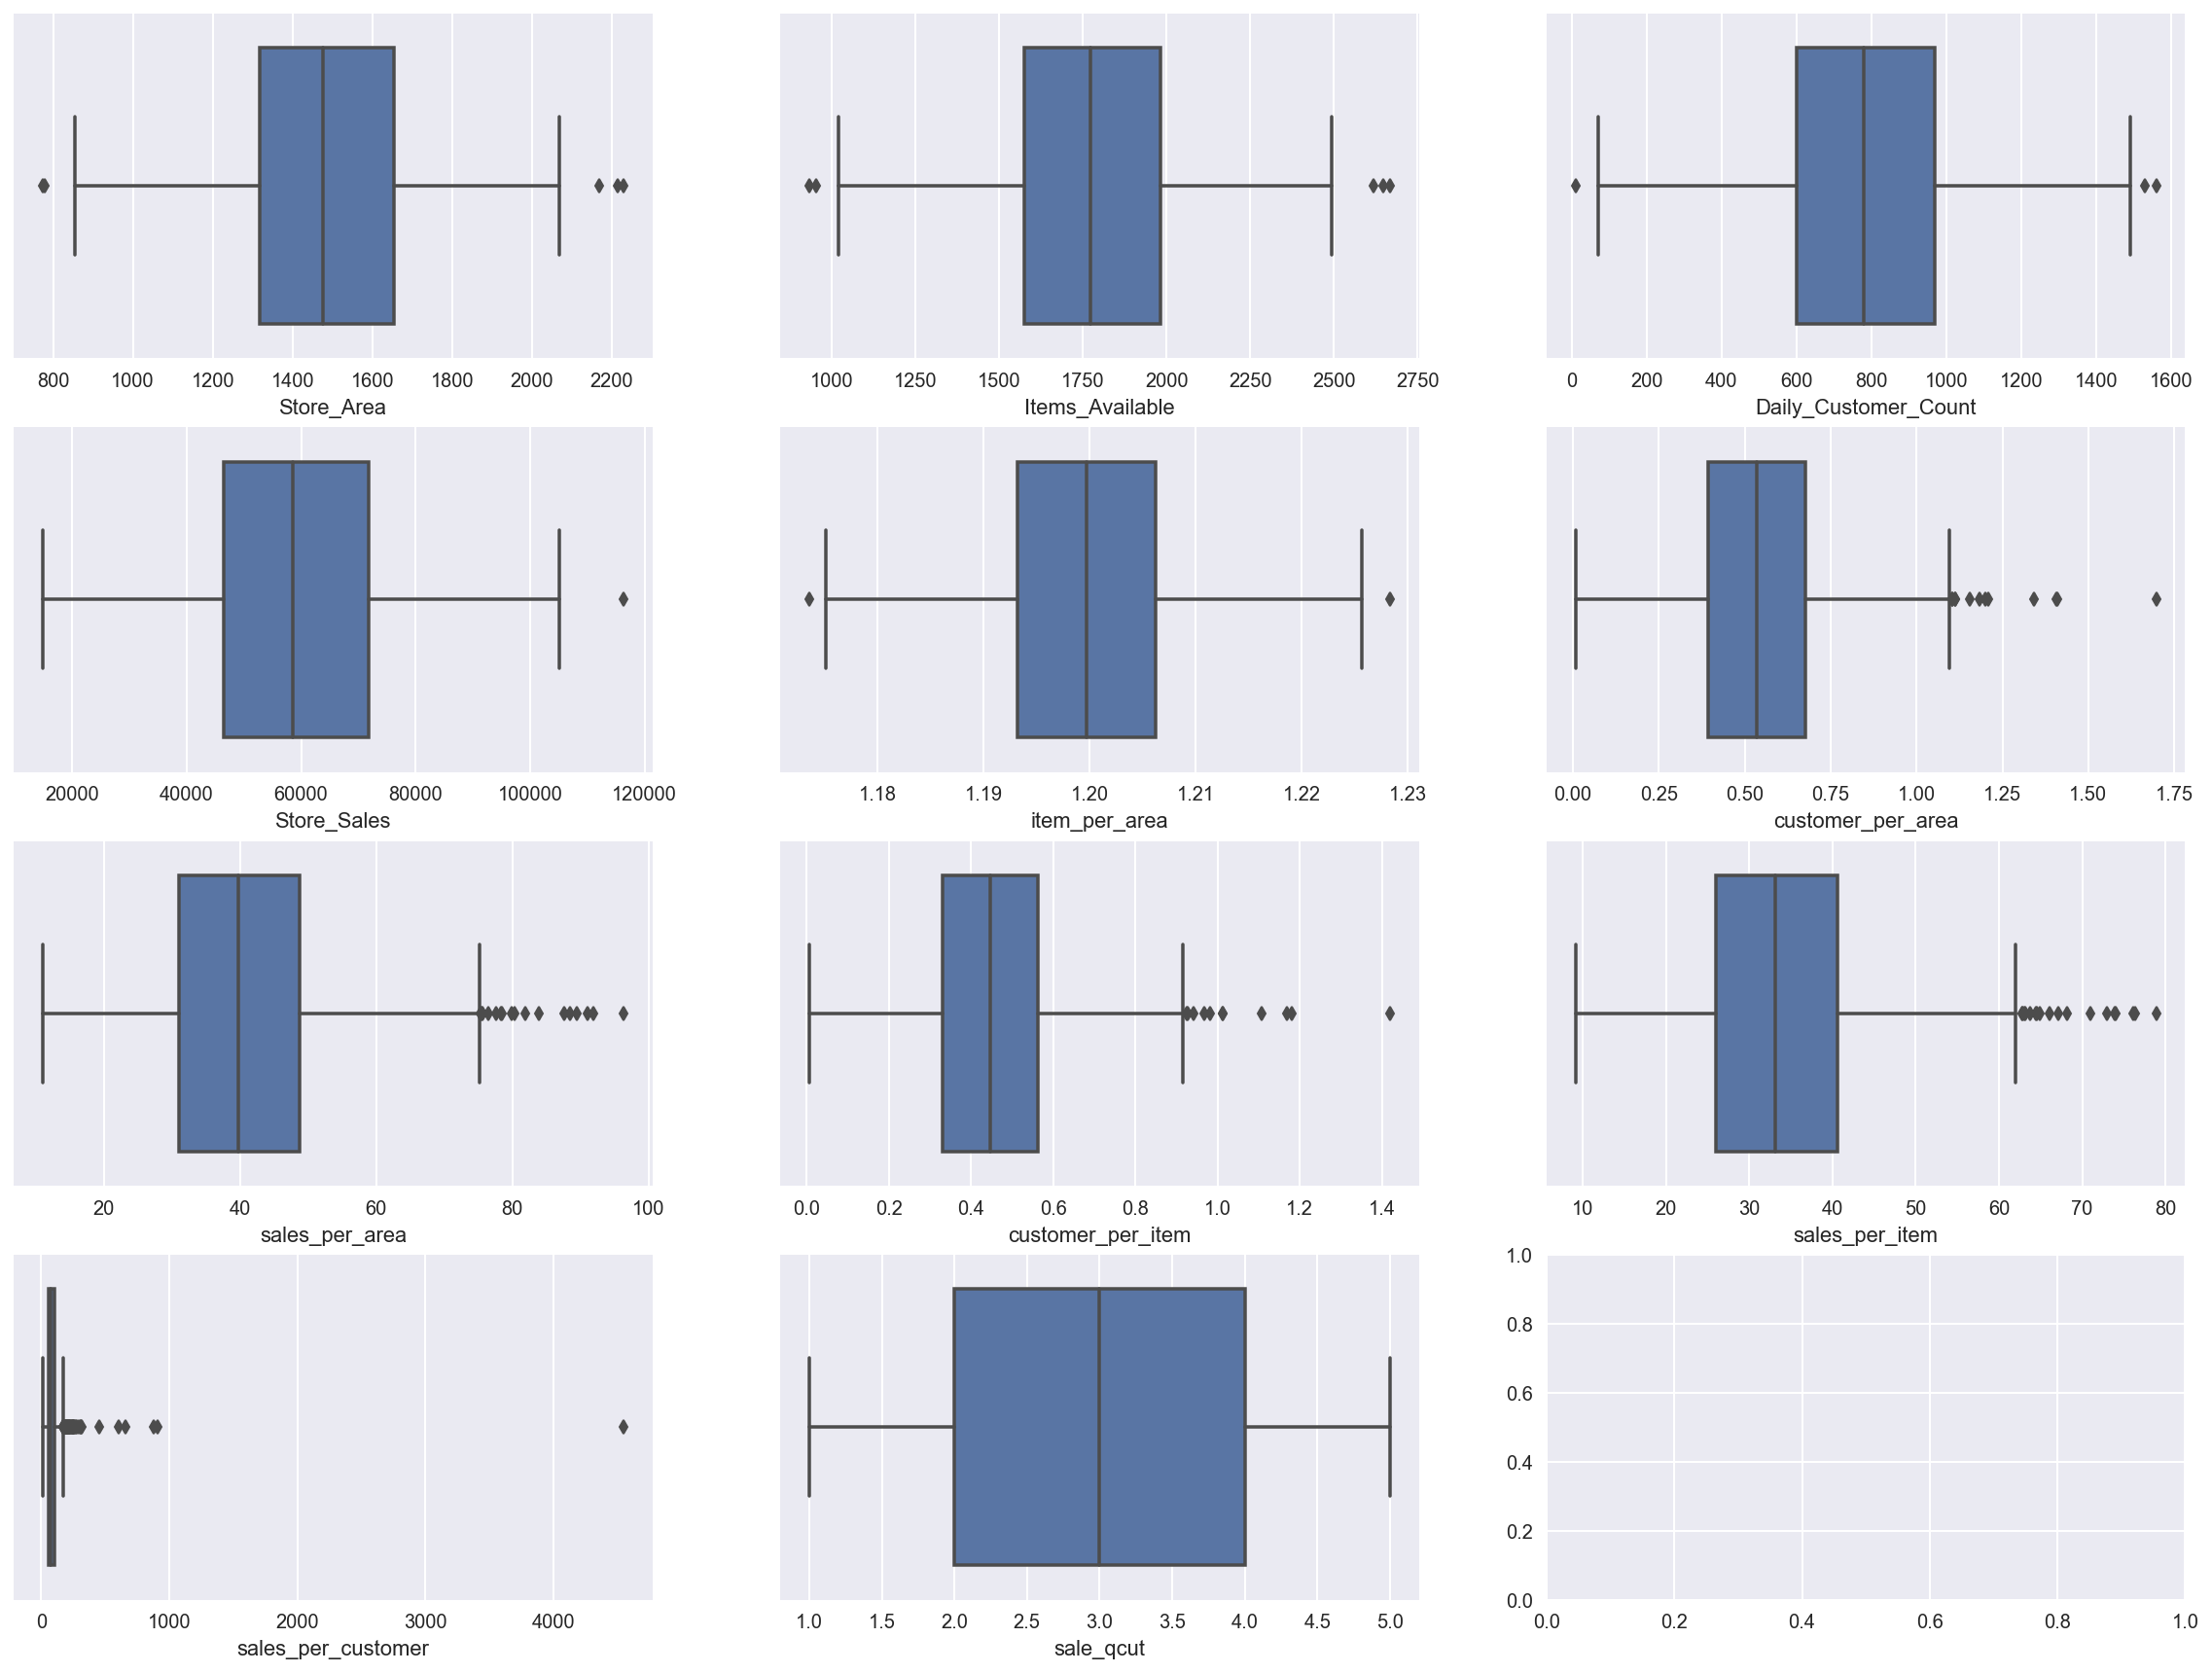

In [222]:
f, ax = plt.subplots(4,3,figsize=(20,15))
count = 0
for row in range(4):
    for col in range(3):
        sns.boxplot(df.iloc[:,count],ax=ax[row,col])
        count+=1
        if count == 11:
            break

In [223]:
def Z_score_count(df):
    li = []
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        li.append((abs(((df[column])-df[column].mean())/df[column].std())>3).sum())

    outlier = pd.DataFrame({'columns':df.columns})
    outlier['num'] = li
    return outlier.sort_values('num',ascending=False)  

def Z_score_count(df):
    li = []
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        li.append((abs(((df[column])-df[column].mean())/df[column].std())>3).sum())

    outlier = pd.DataFrame({'columns':df.columns})
    outlier['num'] = li
    return outlier.sort_values('num',ascending=False)  


def std_count(df):
    li = []
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        maximum = mean +(std)*3
        minimum = mean -(std)*3
        li.append(len(df[(df[column]>maximum) | (df[column]<minimum)]))

    outlier = pd.DataFrame({'columns':df.columns})
    outlier['num'] = li
    return outlier.sort_values('num',ascending=False)

def IQR_out_count(df):         # IQR 방식 이상치 탐지
    li = []
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = (Q3-Q1) * 1.5
        maximum = Q3 + IQR
        minimum = Q1 - IQR
        li.append(len(df[(df[column]>maximum) | (df[column]<minimum)]))

    outlier = pd.DataFrame({'columns':df.columns})
    outlier['num'] = li
    return outlier.sort_values('num',ascending=False)


In [224]:
def iso(df,max_sample=500):
    from sklearn.ensemble import IsolationForest
    isol = IsolationForest(max_samples=max_sample)
    isol.fit(df)
    return isol.predict(df)

In [225]:
Z_score_count(df)

,columns,num
6,sales_per_area,7
8,sales_per_item,7
5,customer_per_area,6
7,customer_per_item,6
9,sales_per_customer,5
3,Store_Sales,1
4,item_per_area,1
0,Store_Area,0
1,Items_Available,0
2,Daily_Customer_Count,0


In [226]:
std_count(df)

,columns,num
6,sales_per_area,7
8,sales_per_item,7
5,customer_per_area,6
7,customer_per_item,6
9,sales_per_customer,5
3,Store_Sales,1
4,item_per_area,1
0,Store_Area,0
1,Items_Available,0
2,Daily_Customer_Count,0


In [227]:
IQR_out_count(df)

,columns,num
9,sales_per_customer,54
8,sales_per_item,18
6,sales_per_area,17
5,customer_per_area,12
7,customer_per_item,11
0,Store_Area,5
1,Items_Available,5
11,pca,5
2,Daily_Customer_Count,3
4,item_per_area,2


- z-score과 std방식은 코드만 다를뿐 작동원리가 같기에 같은 결과값이 나왔다.
- IQR방식은 이상치가 상대적으로 많이나왔다.

위 두방식은 모두 이상치에 민감하다 ->  mean또는 사분위수를 사용하기 때문이다.

In [228]:
df_3 = df_original.copy()

In [229]:
df_3['iso']=iso(df)

In [230]:
df_3.iso.value_counts()

 1    776
-1    120
Name: iso, dtype: int64

<AxesSubplot:xlabel='Store_Area', ylabel='Store_Sales'>

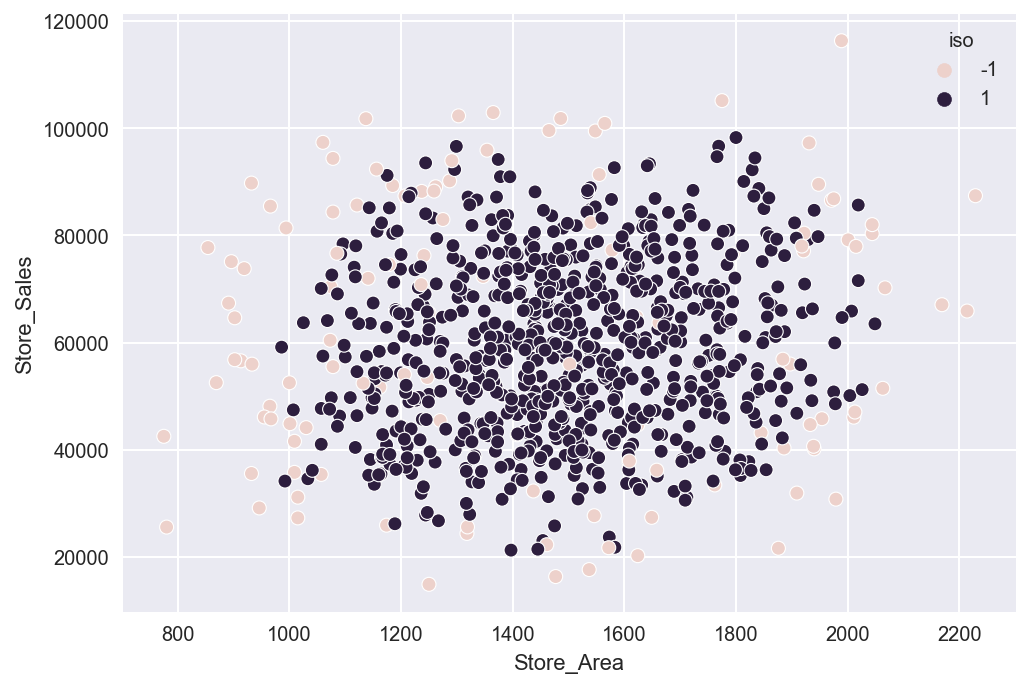

In [231]:
sns.scatterplot(x='Store_Area',y='Store_Sales',data=df_3,hue='iso')

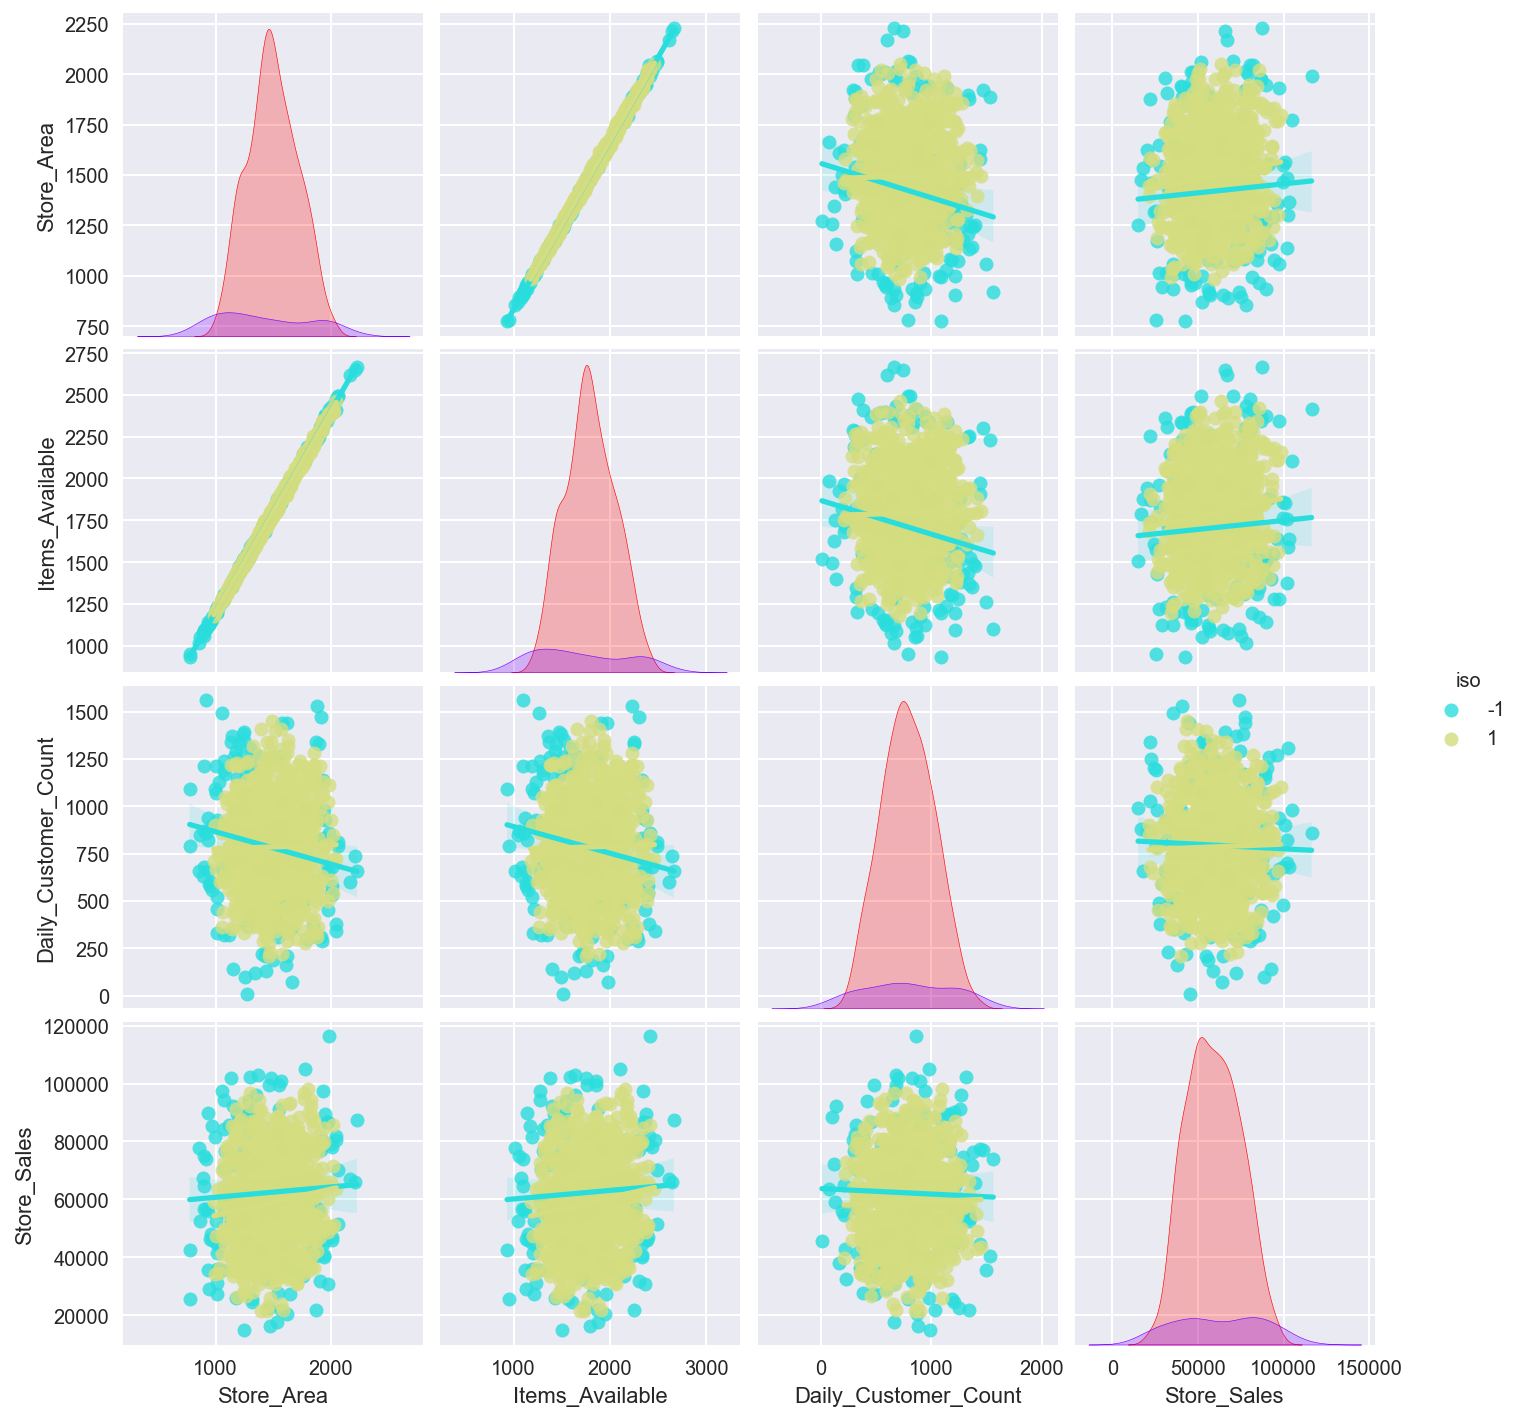

In [232]:
sns.pairplot(df_3,kind='reg',palette='rainbow',hue='iso')

<AxesSubplot:xlabel='Store_Area', ylabel='Items_Available'>

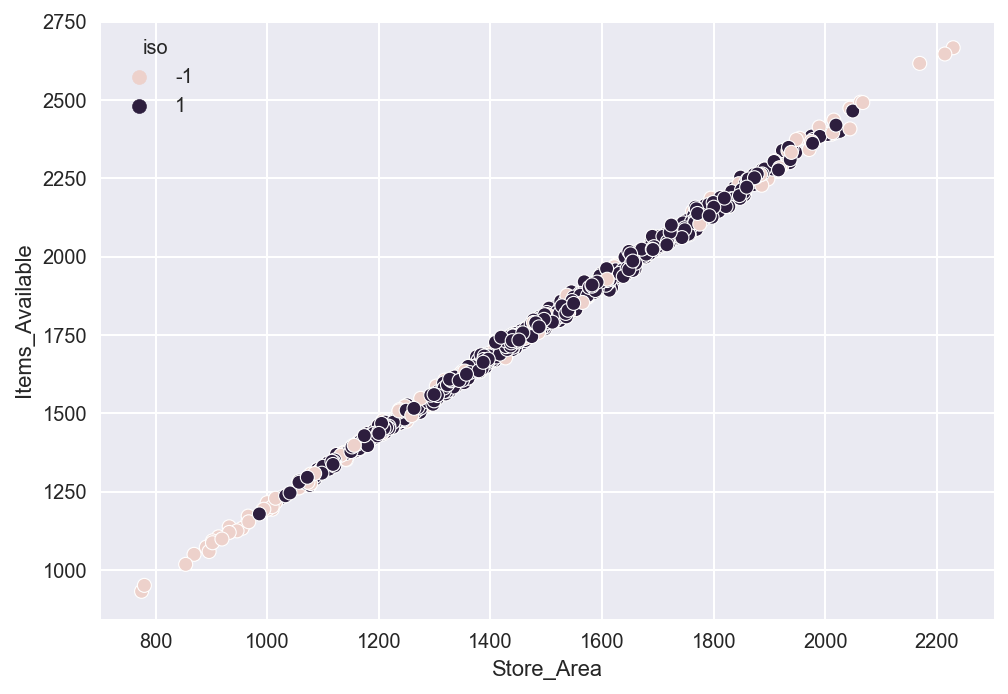

In [233]:
sns.scatterplot(x='Store_Area',y='Items_Available',data=df_3,hue='iso')

- 단일 feature별 이상치를 탐지하는것이 아닌 전체 feature에 대한 이상치를 탐지하기에 중간중간에도 이상치가 보인다.

In [234]:
dbscan = DBSCAN(eps=10, min_samples=5).fit(df_original[['Store_Area','Items_Available']])
pd.DataFrame(dbscan.labels_).value_counts()

 0     412
-1     151
 2     122
 9      36
 3      30
 6      21
 11     21
 12     21
 1      13
 10      9
 4       8
 13      8
 15      8
 7       7
 8       6
 14      6
 5       5
 16      5
 17      4
 18      3
dtype: int64

In [235]:
df_4=df_original.drop('sale_qcut',1)
df_4 = df_4.apply(lambda x : np.log1p(x))

In [236]:
dbscan = DBSCAN(eps=0.1, min_samples=5).fit(df_4[['Store_Area','Items_Available']])
pd.DataFrame(dbscan.labels_).value_counts()

 0    894
-1      2
dtype: int64

In [237]:
df_4['dbscan'] = dbscan.labels_

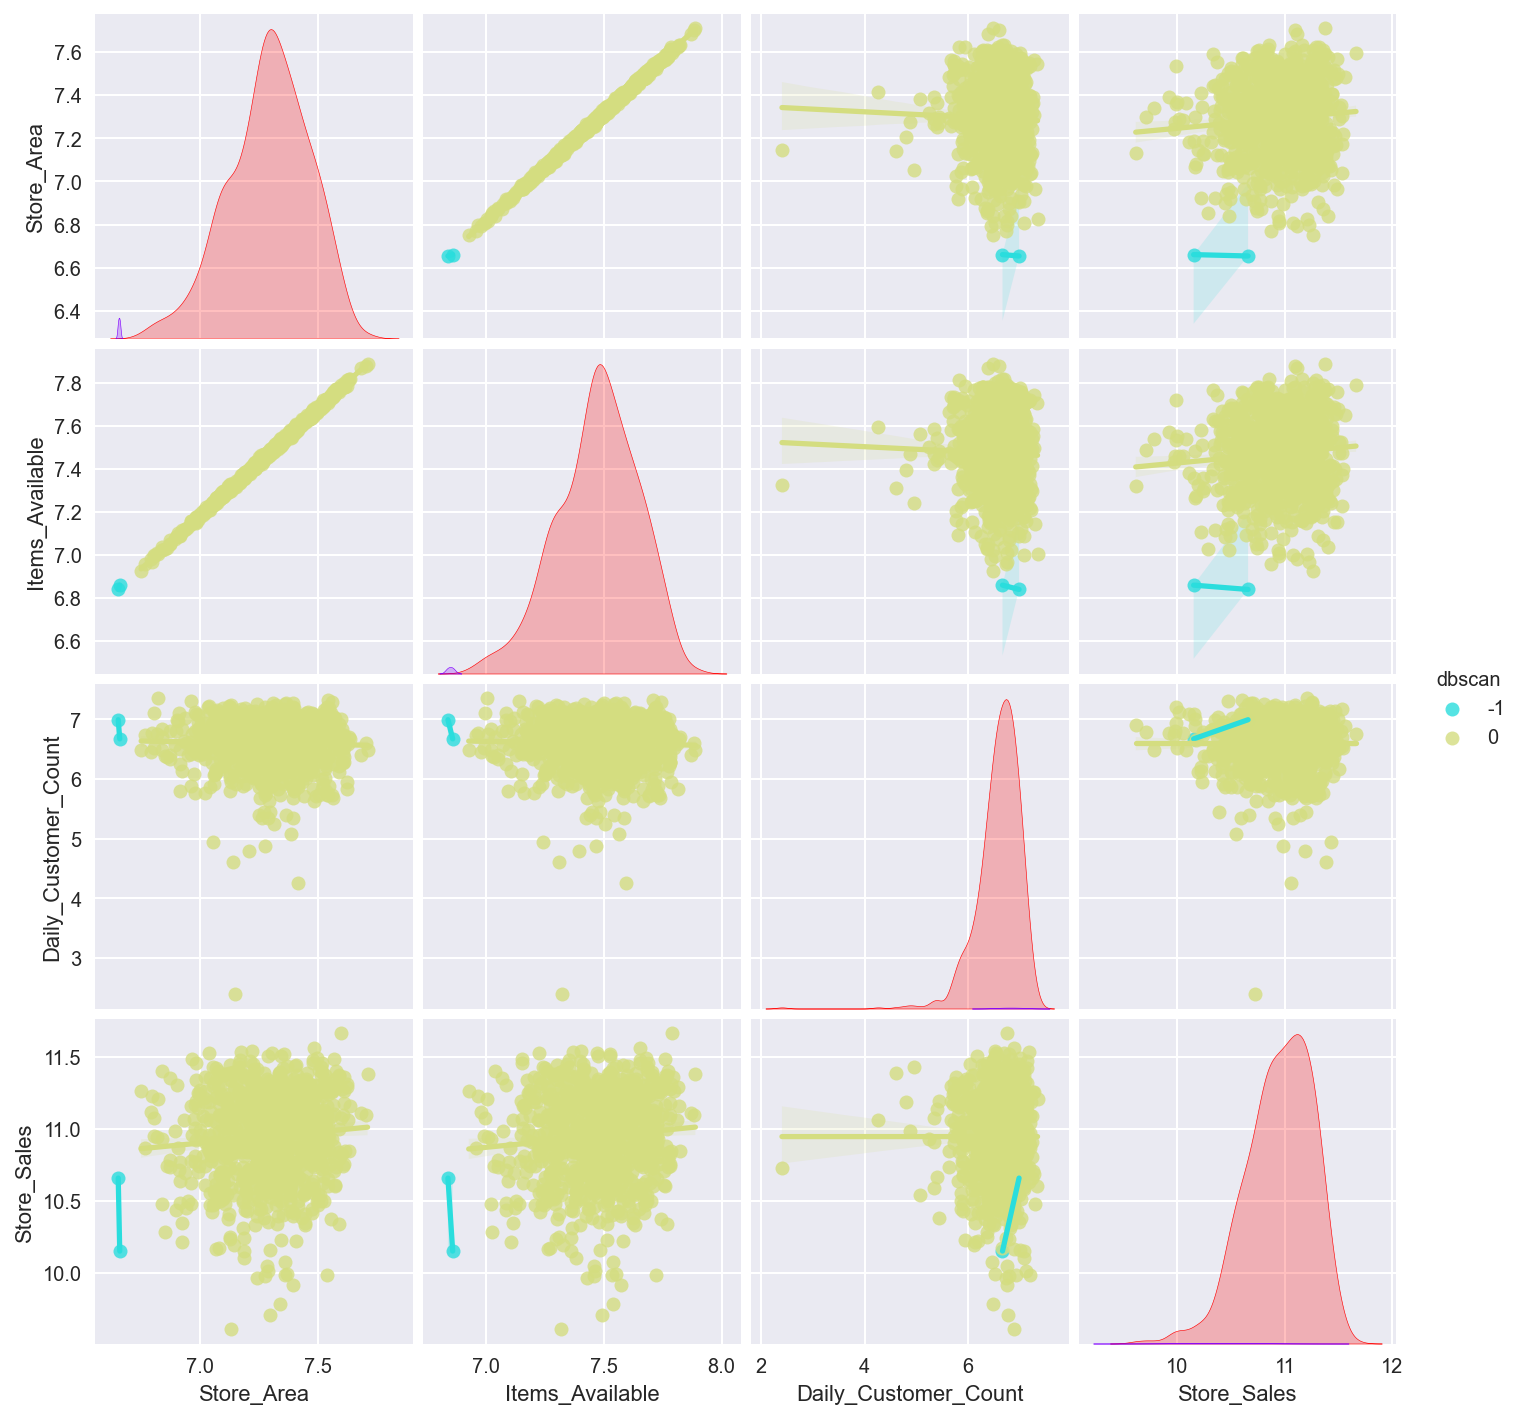

In [238]:
sns.pairplot(df_4,kind='reg',palette='rainbow',hue='dbscan')

<AxesSubplot:xlabel='Store_Area', ylabel='Items_Available'>

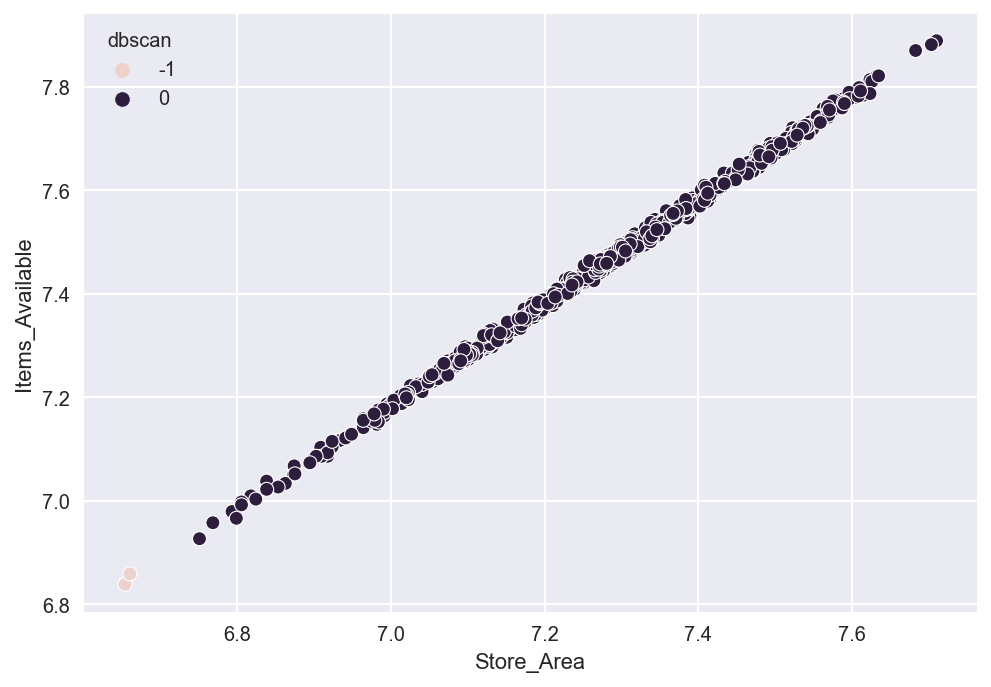

In [239]:
sns.scatterplot(x='Store_Area',y='Items_Available',data=df_log,hue='dbscan')

- DBSCAN이 2개의 이상치를 판단하였고 이를 feature별 시각화를 통하여 이상치를 확인해보았다. 그결과 이상치가 기존 데이터들과 어느정도 떨어져 있는것이 확인된다.
- 다만 DBSCNA은 데이터가 늘어나면 계산량이 증가하여 자원이 많이 소모된다.

In [240]:
# from mpl_toolkits.mplot3d import axes3d
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.scatter(xs='Store_Area',ys='Items_Available',zs='Store_Sales',data=df_log)

### 2.2.0 Store_Sales

In [241]:
[df.Store_Sales.min(),df.Store_Sales.max()] #범위

[14920, 116320]

<AxesSubplot:xlabel='Store_Sales'>

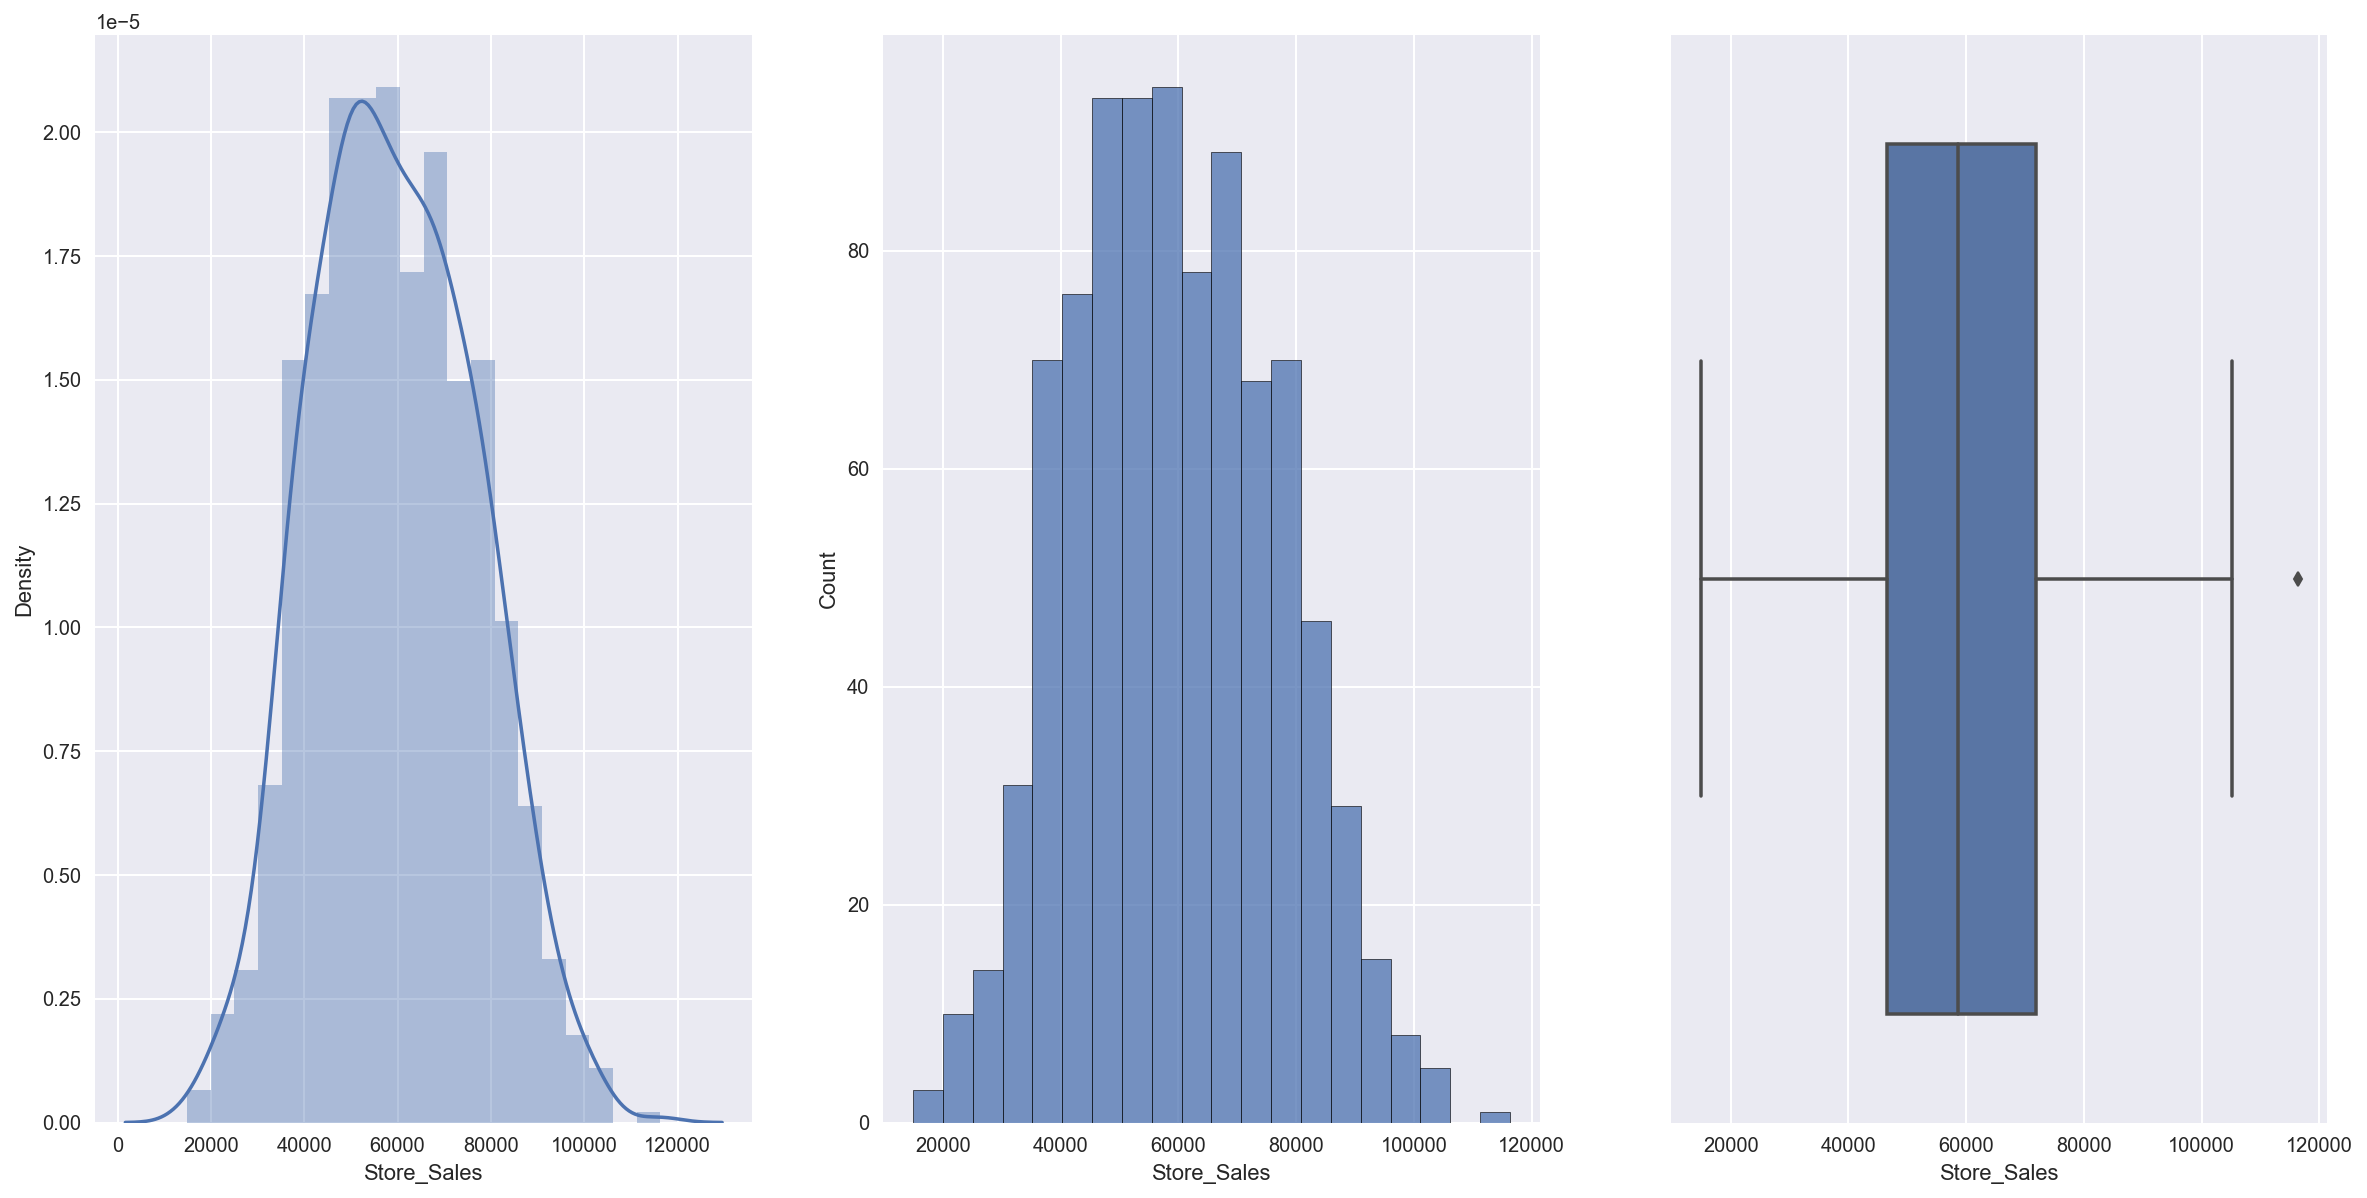

In [242]:
f, ax = plt.subplots(1,3,figsize=(20,10))
sns.distplot(df.Store_Sales,ax=ax[0])
sns.histplot(df.Store_Sales,ax=ax[1])
sns.boxplot(df.Store_Sales,ax=ax[2])

### 2.2.1 Store_Area

In [243]:
df[['Store_Area','sale_qcut','Store_Sales']]

,Store_Area,sale_qcut,Store_Sales
0,1659,4,66490
1,1461,1,39820
2,1340,3,54010
3,1451,2,53730
4,1770,2,46620
...,...,...,...
891,1582,4,66390
892,1387,5,82080
893,1200,5,76440
894,1299,5,96610


,Store_Area
sale_qcut,
1,1442.283333
2,1483.972222
3,1479.224719
4,1498.564246
5,1523.217877


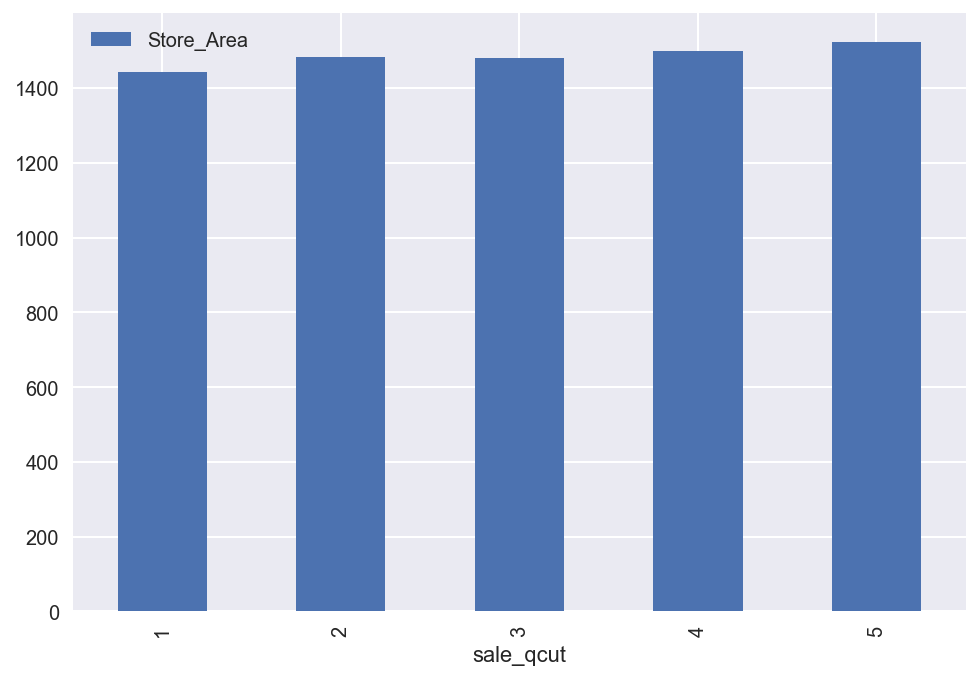

In [244]:
df[['Store_Area','sale_qcut']].groupby('sale_qcut').mean().plot(kind='bar')
df[['Store_Area','sale_qcut']].groupby('sale_qcut').mean()

<AxesSubplot:xlabel='Store_Area', ylabel='Store_Sales'>

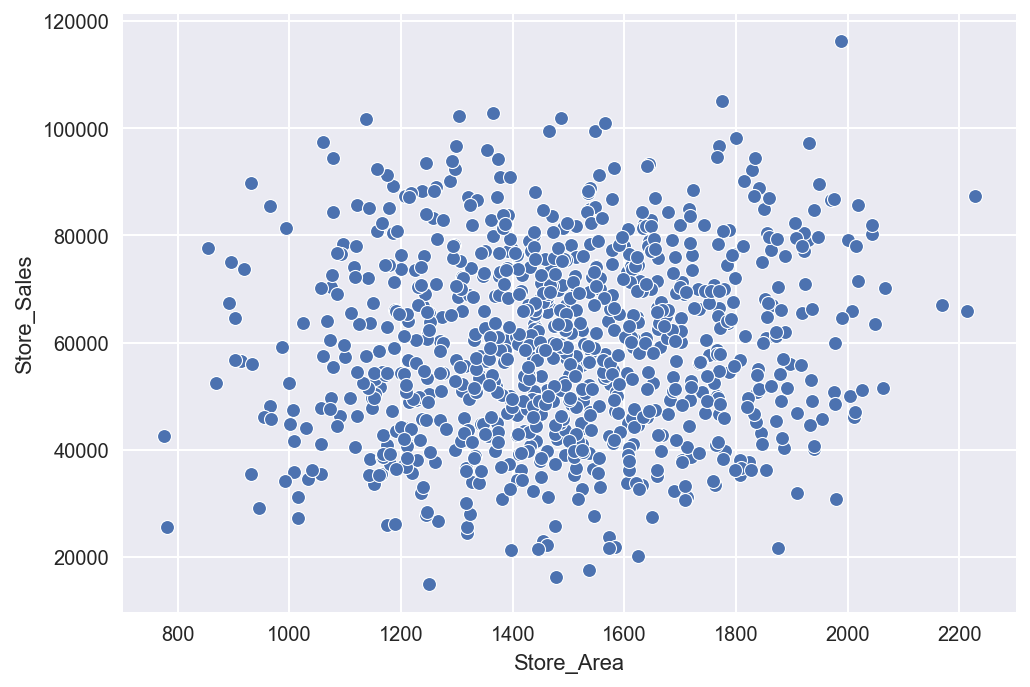

In [245]:
sns.scatterplot(data=df,x='Store_Area',y='Store_Sales')

- 상점의 크기는 판매액과 큰 상관성을 보이지 않는다. 또한 판매액에 따른 면적의 크기를 시각화 및 통계적으로 보아도 유의성이 없어보인다.

### 2.2.2 Items_Available

In [246]:
df[['Items_Available','sale_qcut','Store_Sales']]

,Items_Available,sale_qcut,Store_Sales
0,1961,4,66490
1,1752,1,39820
2,1609,3,54010
3,1748,2,53730
4,2111,2,46620
...,...,...,...
891,1910,4,66390
892,1663,5,82080
893,1436,5,76440
894,1560,5,96610


,Items_Available
sale_qcut,
1,1729.833333
2,1780.583333
3,1773.803371
4,1798.340782
5,1827.871508


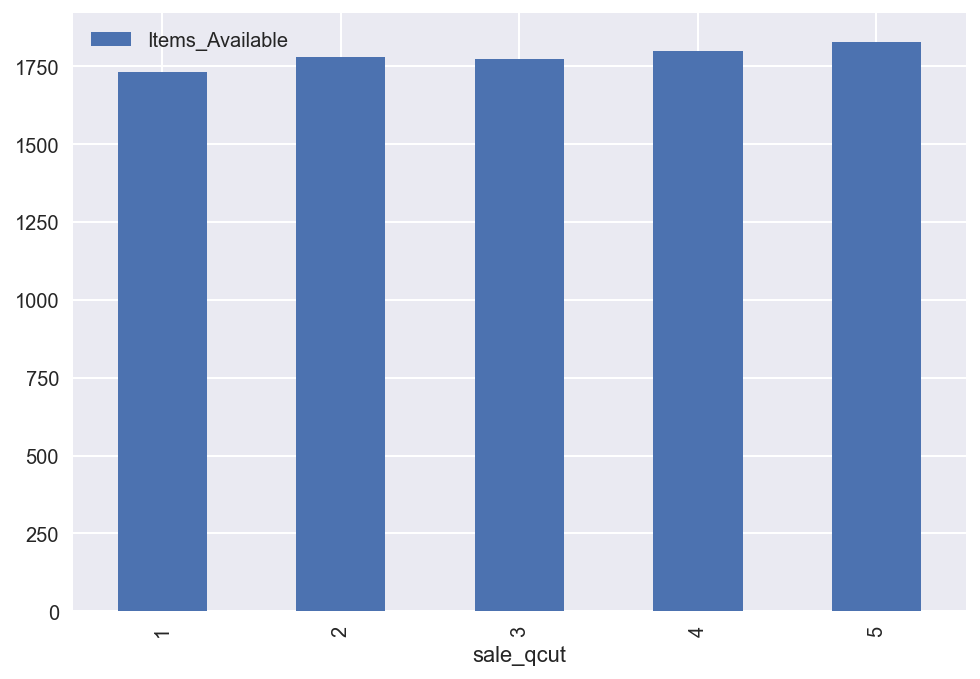

In [247]:
df[['Items_Available','sale_qcut']].groupby('sale_qcut').mean().plot(kind='bar')
df[['Items_Available','sale_qcut']].groupby('sale_qcut').mean()

- 상품수 또한 그 개수가 적건 많건 판매액과는 연관성이 안보인다.

### 2.2.3 Daily_Customer_Count

In [248]:
df[['Daily_Customer_Count','sale_qcut','Store_Sales']]

,Daily_Customer_Count,sale_qcut,Store_Sales
0,530,4,66490
1,210,1,39820
2,720,3,54010
3,620,2,53730
4,450,2,46620
...,...,...,...
891,1080,4,66390
892,850,5,82080
893,1060,5,76440
894,770,5,96610


,Daily_Customer_Count
sale_qcut,
1,777.666667
2,788.777778
3,798.539326
4,775.586592
5,791.284916


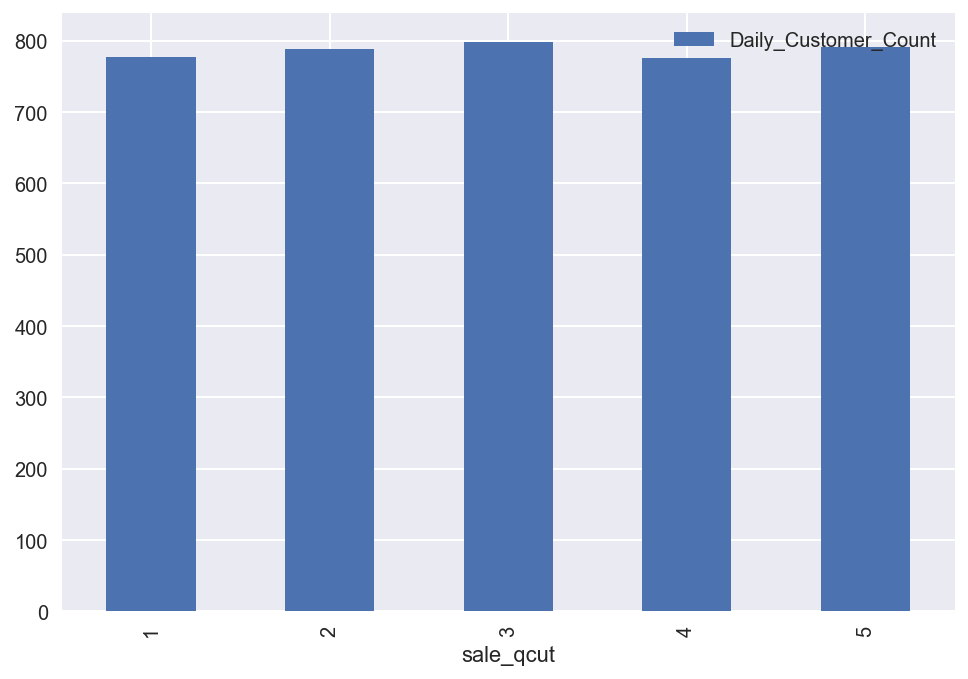

In [249]:
df[['Daily_Customer_Count','sale_qcut']].groupby('sale_qcut').mean().plot(kind='bar')
df[['Daily_Customer_Count','sale_qcut']].groupby('sale_qcut').mean()

# 3.Feature Engineering

#### feature drop

In [415]:
url = 'C:\\Users\\Lee\\Desktop\\GIt\\AIFFEL_first\\Dataton/'
df = pd.read_csv(url +'Stores.csv')
df.drop('Store ID ',axis=1,inplace=True)

#### PCA를 통한 차원축소

In [416]:
pca = PCA(n_components = 1)
df['pca'] = pca.fit_transform(df[['Store_Area','Items_Available']])
df.drop(['Store_Area','Items_Available'],axis=1,inplace=True)

#### Scaling

In [417]:
# MinMax Scalaer 정규회
def minmax(df1): # 0 ~ 1 사이값 -> 이상치에 민감하다.
    df  = df1.copy()
    for column in df.columns:
        max_value = df[column].max()
        min_value = df[column].min()
        df[column] = df[column].apply(lambda x : (x-min_value)/(max_value-min_value))
    return df

# Standard Scaler  표준화
def standard(df1): # mean =0 , std =1  -> 무난한 scaler
    df = df1.copy()
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()        
        df[column] = df[column].apply(lambda x : (x-mean)/(std))
    return df

# Log Scaler 
def log(df1): # 몰여있거나 넓게 퍼진값들을 모아준다. !!!!! 음수값 들어오면 NAN된다.
    df = df1.copy()
    for column in df.columns:
        if df[column].min() < 0:
            df[column] = df[column]-df[column].min() +1
        df[column]+=1
        df[column]=np.log1p(df[column])
    return df

# Robuser Sclaer
def robust(df1):
    df = df1.copy()
    for column in df.columns:
        median =df[column].median()
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        df[column] = df[column].apply(lambda x : (x-median)/(Q3-Q1))
    return df    

In [418]:
minmax(df)

,Daily_Customer_Count,Store_Sales,pca
0,0.335484,0.508580,0.599212
1,0.129032,0.245562,0.472285
2,0.458065,0.385503,0.389536
3,0.393548,0.382742,0.468098
4,0.283871,0.312623,0.681506
...,...,...,...
891,0.690323,0.507594,0.560122
892,0.541935,0.662327,0.421154
893,0.677419,0.606706,0.291234
894,0.490323,0.805621,0.361312


In [419]:
standard(df)

,Daily_Customer_Count,Store_Sales,pca
0,-0.965941,0.415264,0.636747
1,-2.171717,-1.136153,-0.099115
2,-0.250012,-0.310708,-0.578852
3,-0.626817,-0.326996,-0.123388
4,-1.267385,-0.740591,1.113843
...,...,...,...
891,1.106486,0.409447,0.410120
892,0.239835,1.322147,-0.395547
893,1.031125,0.994064,-1.148758
894,-0.061609,2.167370,-0.742480


In [420]:
log(df)

,Daily_Customer_Count,Store_Sales,pca
0,6.276643,11.104837,7.214824
1,5.356586,10.592175,6.977383
2,6.582025,10.896962,6.785351
3,6.432940,10.891764,6.968503
4,6.113682,10.749828,7.343246
...,...,...,...
891,6.986566,11.103332,7.147516
892,6.747587,11.315474,6.863138
893,6.967909,11.244288,6.495664
894,6.648985,11.478458,6.710401


In [421]:
robust(df)

,Daily_Customer_Count,Store_Sales,pca
0,-0.675676,0.311137,0.487467
1,-1.540541,-0.741245,-0.053114
2,-0.162162,-0.181316,-0.405541
3,-0.432432,-0.192365,-0.070946
4,-0.891892,-0.472921,0.837953
...,...,...,...
891,0.810811,0.307191,0.320982
892,0.189189,0.926310,-0.270881
893,0.756757,0.703759,-0.824208
894,-0.027027,1.499655,-0.525746


In [422]:
df_mm = minmax(df)
df_std = standard(df) 
df_log = log(df)
df_rob = robust(df)

#### 이상치 제거

In [423]:
dbscan = DBSCAN(eps=0.1, min_samples=5).fit(df)
pd.DataFrame(dbscan.labels_).value_counts()

-1    896
dtype: int64

In [424]:
dbscan = DBSCAN(eps=0.2, min_samples=5).fit(df_mm)
print(pd.DataFrame(dbscan.labels_).value_counts())
print('\n-------------------------------------')

dbscan = DBSCAN(eps=1.2, min_samples=5).fit(df_std)
print(pd.DataFrame(dbscan.labels_).value_counts())
print('\n-------------------------------------')

dbscan = DBSCAN(eps=1, min_samples=5).fit(df_log)
print(pd.DataFrame(dbscan.labels_).value_counts())
print('\n-------------------------------------')

dbscan = DBSCAN(eps=0.8, min_samples=5).fit(df_rob)
print(pd.DataFrame(dbscan.labels_).value_counts())
print('\n-------------------------------------')


 0    894
-1      2
dtype: int64

-------------------------------------
 0    895
-1      1
dtype: int64

-------------------------------------
 0    893
-1      3
dtype: int64

-------------------------------------
 0    892
-1      4
dtype: int64

-------------------------------------


In [425]:
df_1 =df.copy()

In [426]:
df_1['dbscan'] = DBSCAN(eps=1.2, min_samples=5).fit(df_std).labels_

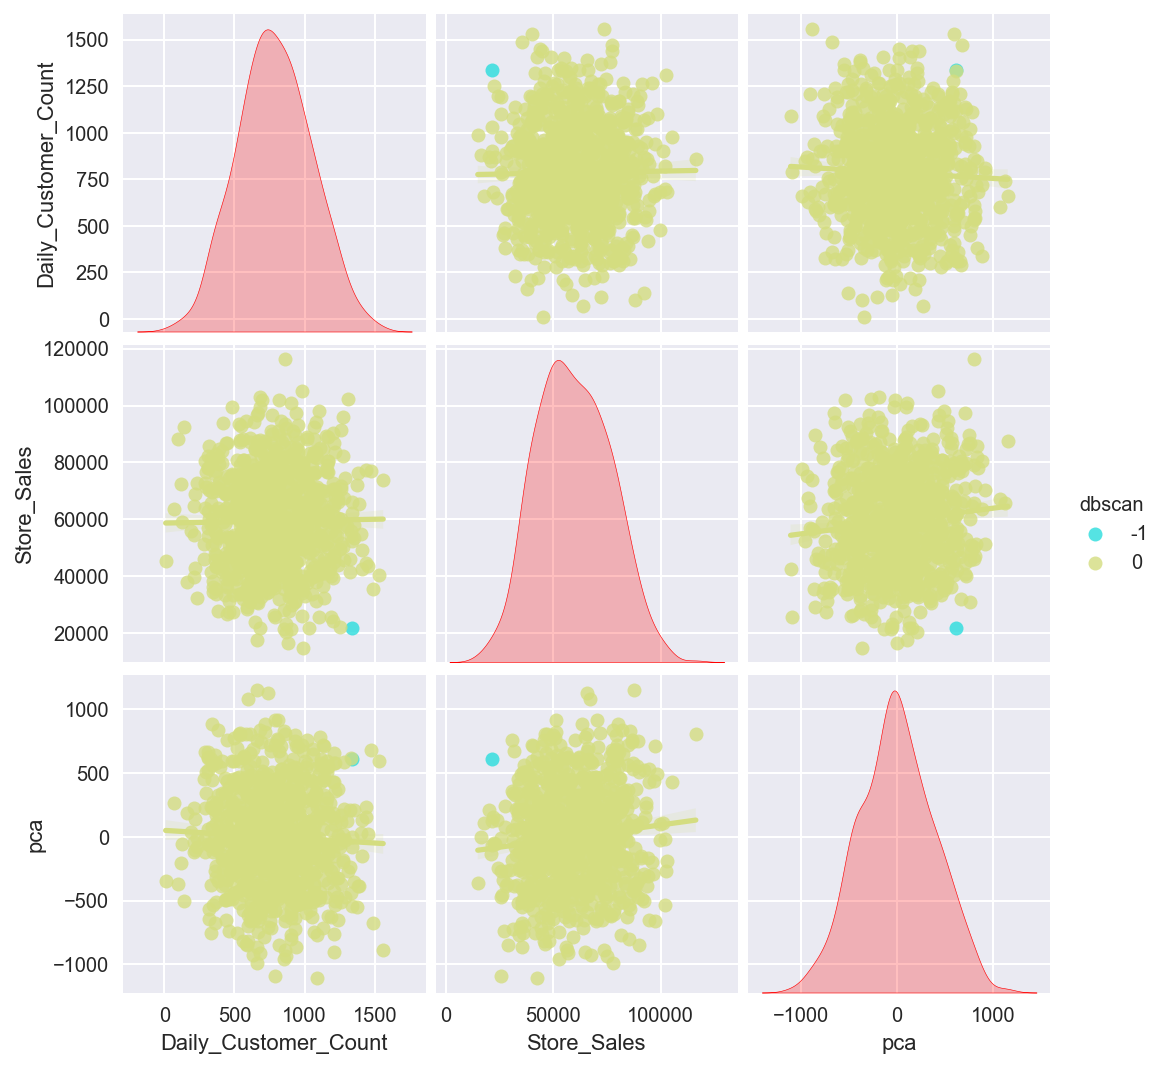

In [427]:
sns.pairplot(df_1,kind='reg',palette='rainbow',hue='dbscan')

In [428]:
df_1[df_1.dbscan==-1]

,Daily_Customer_Count,Store_Sales,pca,dbscan
372,1340,21650,612.621582,-1


In [431]:
df_std.drop(372,inplace=True)
df_std.reset_index(drop=True,inplace=True)

In [432]:
df_std

,Daily_Customer_Count,Store_Sales,pca
0,-0.965941,0.415264,0.636747
1,-2.171717,-1.136153,-0.099115
2,-0.250012,-0.310708,-0.578852
3,-0.626817,-0.326996,-0.123388
4,-1.267385,-0.740591,1.113843
...,...,...,...
890,1.106486,0.409447,0.410120
891,0.239835,1.322147,-0.395547
892,1.031125,0.994064,-1.148758
893,-0.061609,2.167370,-0.742480


# 4. Baseline

In [435]:
df = df_std
target = df['Store_Sales']
df.drop(['Store_Sales'],axis=1,inplace=True)

In [436]:
df

,Daily_Customer_Count,pca
0,-0.965941,0.636747
1,-2.171717,-0.099115
2,-0.250012,-0.578852
3,-0.626817,-0.123388
4,-1.267385,1.113843
...,...,...
890,1.106486,0.410120
891,0.239835,-0.395547
892,1.031125,-1.148758
893,-0.061609,-0.742480


In [439]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

x_train,x_test,y_train,y_test = train_test_split(df,target,random_state=42,test_size=0.2)
lgbm = LGBMRegressor()

In [441]:
lgbm.fit(x_train,y_train)
y_pre = lgbm.predict(x_test)

In [443]:
def rmse(y_test,y_pred):
    return (((y_test-y_pred)**2)/len(y_test))**0.5

In [444]:
rmse(y_test,y_pre)

711    0.055884
440    0.037687
525    0.001113
722    0.096699
39     0.113211
         ...   
433    0.010010
830    0.025696
25     0.006134
84     0.154210
10     0.017980
Name: Store_Sales, Length: 179, dtype: float64